In [9]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random

from neurovae import AsymDNNVAE, bce_loss, gaussian_kld, load_mnist, plot_digits

from plot_utils import plot_comparison

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
encoder_hidden_dims = (500, 150)
decoder_hidden_dims = (200, 450)
latent_dim = 20
output_dim = 784
batch_size = 64
epochs = 100
seed = 42

batches, ds_test = load_mnist(
    batch_size=batch_size,
    drop_remainder=True,
    select_digits=[0, 1, 2, 3],
    as_supervised=False,
    binarized=True,
    shuffle=True,
    shuffle_seed=42,
)

# set values for learning rate scheduler
total_steps = len(batches) * epochs
init_lr = 1e-3
alpha_lr = 1e-2

ds_test = jax.device_put(ds_test)

In [11]:
def model():
    return AsymDNNVAE(encoder_hidden_dims, latent_dim, decoder_hidden_dims, output_dim)


def init_model(rng):
    rng, init_key = random.split(rng)

    initial_variables = jnp.ones((batch_size, output_dim), jnp.float32)
    params = model().init(init_key, initial_variables, rng)["params"]
    del initial_variables, init_key

    lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
    optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule, nesterov=True))

    state = train_state.TrainState.create(
        apply_fn=model().apply,
        params=params,
        tx=optimizer,
    )
    return rng, state


def compute_metrics(recon_x, x, mean, logvar):
    bce = bce_loss(recon_x, x).mean()  # mean over batch
    kld = gaussian_kld(mean, logvar).mean()  # mean over batch
    elbo = bce + kld
    return {"elbo": elbo, "bce": bce, "kld": kld}


@jax.jit
def train_step(state, batch, z_rng):

    def loss_fn(params):
        recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
        bce = bce_loss(recon_x, batch).mean()
        kld = gaussian_kld(mean, logvar).mean()
        elbo = bce + kld
        return elbo

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)


@jax.jit
def eval_f(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)

        recon_images_compare = nn.sigmoid(recon_images[:8])
        comparison = jnp.concatenate(
            [
                images[:8].reshape(-1, 28, 28, 1),
                recon_images_compare.reshape(-1, 28, 28, 1),
            ]
        )

        generate_images = vae.generate(z, assumption="bernoulli")
        generate_images = generate_images.reshape(-1, 28, 28, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, model())({"params": params})

In [12]:
rng = random.key(seed)
rng, state = init_model(rng)

rng, z_key, eval_rng = random.split(rng, 3)

z = random.normal(z_key, (batch_size, latent_dim))  # prior
del z_key

epoch_metrics = []
for epoch in range(epochs):
    for batch in batches:
        rng, key = random.split(rng)
        state = train_step(state, batch, key)

    metrics, comparison, samples = eval_f(state.params, ds_test, z, eval_rng)
    metrics["epoch"] = epoch + 1
    epoch_metrics.append(metrics)
    print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, BCE: {metrics['bce']:.4f}, KLD: {metrics['kld']:.4f}")

epoch: 1, ELBO: 105.2361, BCE: 84.1105, KLD: 21.1256
epoch: 2, ELBO: 93.3997, BCE: 69.4985, KLD: 23.9012
epoch: 3, ELBO: 89.0835, BCE: 64.1427, KLD: 24.9409
epoch: 4, ELBO: 86.9528, BCE: 61.8047, KLD: 25.1481
epoch: 5, ELBO: 85.1181, BCE: 59.6376, KLD: 25.4805
epoch: 6, ELBO: 83.7408, BCE: 58.1222, KLD: 25.6186
epoch: 7, ELBO: 82.9929, BCE: 56.9042, KLD: 26.0886
epoch: 8, ELBO: 82.2557, BCE: 55.8696, KLD: 26.3861
epoch: 9, ELBO: 81.5552, BCE: 55.4333, KLD: 26.1218
epoch: 10, ELBO: 80.7651, BCE: 54.3750, KLD: 26.3901
epoch: 11, ELBO: 80.9535, BCE: 54.2234, KLD: 26.7301
epoch: 12, ELBO: 80.5808, BCE: 53.6234, KLD: 26.9574
epoch: 13, ELBO: 80.1441, BCE: 53.4959, KLD: 26.6482
epoch: 14, ELBO: 79.7544, BCE: 53.4092, KLD: 26.3452
epoch: 15, ELBO: 79.3305, BCE: 52.7087, KLD: 26.6218
epoch: 16, ELBO: 79.0453, BCE: 52.3281, KLD: 26.7172
epoch: 17, ELBO: 79.0475, BCE: 52.0009, KLD: 27.0466
epoch: 18, ELBO: 79.0005, BCE: 51.8937, KLD: 27.1068
epoch: 19, ELBO: 78.8256, BCE: 52.0283, KLD: 26.7973
e

In [13]:
df = pd.DataFrame(epoch_metrics)
df

,bce,elbo,kld,epoch
0,84.11053,105.23614,21.125612,1
1,69.4985,93.399666,23.901167,2
2,64.142654,89.08351,24.940857,3
3,61.804745,86.952805,25.148064,4
4,59.637554,85.11808,25.480528,5
...,...,...,...,...
95,47.708633,76.20914,28.500504,96
96,47.554176,76.19987,28.645693,97
97,47.663025,76.1825,28.51948,98
98,47.611565,76.1885,28.576935,99


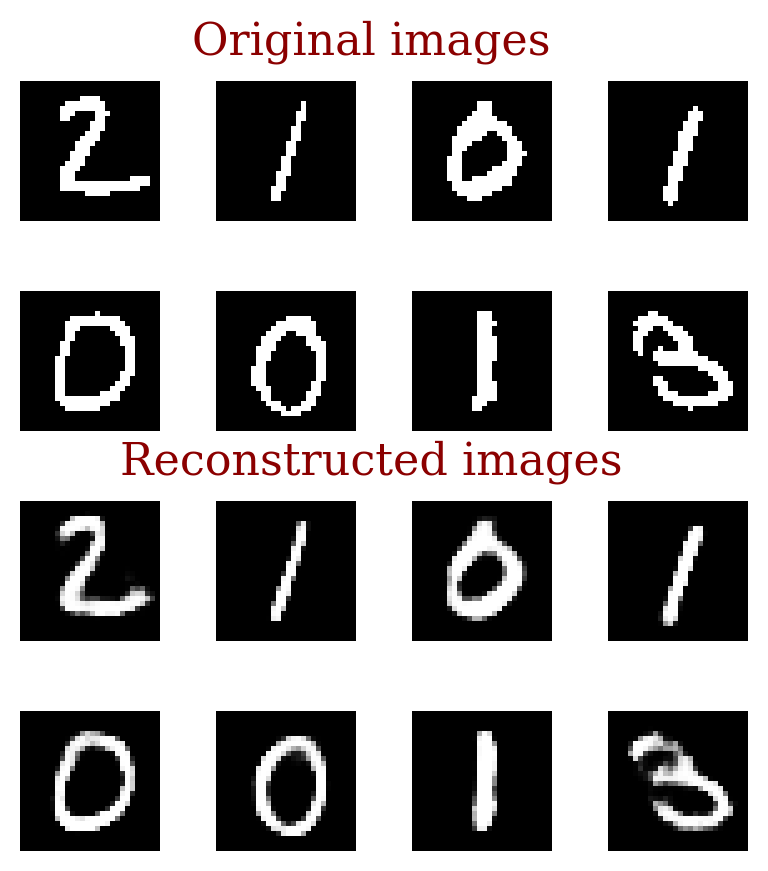

In [14]:
plot_comparison(comparison)
plt.show()

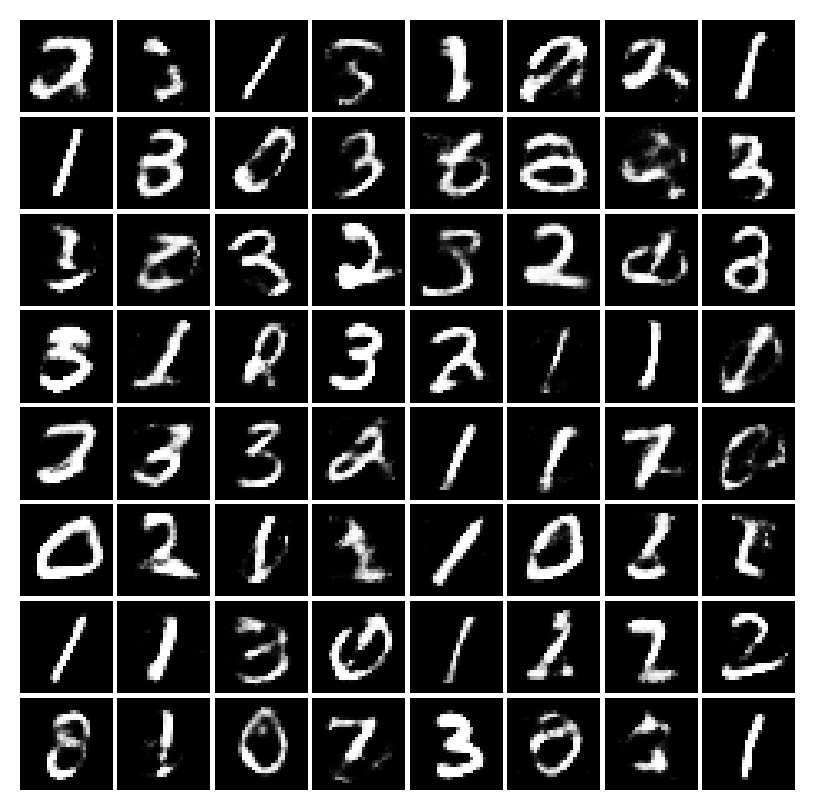

In [15]:
plot_digits(samples)
plt.show()